# Exploring Ensemble Methods

In this homework we will explore the use of boosting. For this assignment, we will use the pre-implemented gradient boosted trees in Turi-Create. You will:

Use SFrames to do some feature engineering.
Train a boosted ensemble of decision-trees (gradient boosted trees) on the lending club dataset.
Predict whether a loan will default along with prediction probabilities (on a validation set).
Evaluate the trained model and compare it with a baseline.
Find the most positive and negative loans using the learned model.
Explore how the number of trees influences classification performance.

In [140]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingClassifier

In [141]:
loans = pd.read_csv('/Users/kevinwang/Documents/Coursera/Machine Learning - Classification/Week4/lending-club-data.csv')  

/Users/kevinwang/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Selecting features
In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are described in the code comments below. If you are a finance geek, the LendingClub website has a lot more details about these features.

The features we will be using are described in the code comments below. Extract these feature columns and target column from the dataset. We will only use these features.

In [142]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies
             'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

In [143]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop('bad_loans', axis = 1)
loans = loans[features + [target]]

## Skipping observations with missing values
Recall from the lectures that one common approach to coping with missing values is to skip observations that contain missing values.

In [144]:
loans = loans[[target] + features].dropna()

In [145]:
def one_hot(loans):
    return pd.get_dummies(loans, dummy_na=True) 
    #return pd.get_dummies(loans, dummy_na=True)   # We don't need to identify Str variable, it will just transform 'object' var
    # dummy_na=True => When emp_length has 'NA', we do create emp_length_NA column
loans = one_hot(loans)

In [146]:
import json
with open('/Users/kevinwang/Documents/Coursera/Machine Learning - Classification/Week5/module-8-assignment-1-train-idx.json', 'r') as f: # Reads the list of most frequent words
    train_idx = json.load(f)
with open('/Users/kevinwang/Documents/Coursera/Machine Learning - Classification/Week5/module-8-assignment-1-validation-idx.json', 'r') as f1: # Reads the list of most frequent words
    validation_idx = json.load(f1)

train_data = loans.iloc[train_idx]
validation_data = loans.iloc[validation_idx]
print(train_data.shape)        #(37219, 25)
print(validation_data.shape)   #(9284, 25)
train_loans_prop = sum(train_data['safe_loans'] == 1)/len(train_data)   #0.5036137456675354   Means data is very balanced
valid_loans_prop = sum(validation_data['safe_loans'] == 1)/len(validation_data)   #0.4967686342093925   Means data is very balanced
y_train = train_data['safe_loans']
x_train = train_data.drop('safe_loans', axis=1)

y_valid = validation_data['safe_loans']
x_valid = validation_data.drop('safe_loans', axis=1)

(37219, 48)
(9284, 48)


## Gradient boosted tree classifier

Gradient boosted trees are a powerful variant of boosting methods; they have been used to win many Kaggle competitions, and have been widely used in industry. We will explore the predictive power of multiple decision trees as opposed to a single decision tree.

Additional reading: If you are interested in gradient boosted trees, here is some additional reading material:

GraphLab Create user guide
Advanced material on boosted trees
We will now train models to predict safe_loans using the features above. In this section, we will experiment with training an ensemble of 5 trees.

Now, let's use the built-in scikit learn gradient boosting classifier (sklearn.ensemble.GradientBoostingClassifier) to create a gradient boosted classifier on the training data. You will need to import sklearn, sklearn.ensemble, and numpy.

You will have to first convert the SFrame into a numpy data matrix. See the API for more information. You will also have to extract the label column. Make sure to set 

max_depth=6 and 

n_estimators=5.

In [147]:
model_5 = GradientBoostingClassifier(n_estimators=5, max_depth=6)
model_5.fit(x_train, y_train)

print("Accuracy score (training): {0:.3f}".format(model_5.score(x_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(model_5.score(x_valid, y_valid)))

Accuracy score (training): 0.665
Accuracy score (validation): 0.661


## Making predictions
Just like we did in previous sections, let us consider a few positive and negative examples from the validation set. We will do the following:

Predict whether or not a loan is likely to default.
Predict the probability with which the loan is likely to default.

First, let's grab 2 positive examples and 2 negative examples. In SFrame, that would be:

In [148]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,purpose_nan
22,1,0.2,0,3,29.44,6.30496,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
26,1,0.6,1,1,12.19,13.49520,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
24,-1,0.4,0,3,13.97,2.96736,3.0,0.0,0.0,0,...,0,0,0,0,0,1,0,0,0,0
41,-1,1.0,0,11,16.33,1.90524,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0


For each row in the sample_validation_data, write code to make model_5 predict whether or not the loan is classified as a safe loan.

In [149]:
model_5.predict(sample_validation_data.drop('safe_loans',1))

array([ 1,  1, -1,  1])

Quiz question: What percentage of the predictions on sample_validation_data did model_5 get correct?

Answer: 75%

## Prediction Probabilities

For each row in the sample_validation_data, what is the probability (according model_5) of a loan being classified as safe? (Hint: if you are using scikit-learn, you can use the .predict_proba() method)

In [150]:
sample_prob = model_5.predict_proba(sample_validation_data.drop('safe_loans',1))
print(sample_prob)
risk_prob = sample_prob[:,0]
safe_prob = sample_prob[:,1]
print(risk_prob)
print(safe_prob)

[[0.41642331 0.58357669]
 [0.46949689 0.53050311]
 [0.53807792 0.46192208]
 [0.39591639 0.60408361]]
[0.41642331 0.46949689 0.53807792 0.39591639]
[0.58357669 0.53050311 0.46192208 0.60408361]


Quiz Question: Which loan has the highest probability of being classified as a safe loan?

Answer: 4th. 

Quiz Question: According to model_5, which loan is the least likely to be a safe loan?

Answer: 3th.
    
Checkpoint: Can you verify that for all the predictions with probability >= 0.5, the model predicted the label +1?

## Evaluating the model on the validation data

Recall that the accuracy is defined as follows:

accuracy=# correctly classified data points / # total data points

Evaluate the accuracy of the model_5 on the validation_data. (Hint: if you are using scikit-learn, you can use the .score() method)

In [151]:
print("Accuracy score (training): {0:.3f}".format(model_5.score(x_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(model_5.score(x_valid, y_valid)))

Accuracy score (training): 0.665
Accuracy score (validation): 0.661


Calculate the number of false positives made by the model on the validation_data.

Calculate the number of false negatives made by the model on the validation_data.

In [152]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model_5.predict(x_valid)

print("Confusion Matrix:")
print(confusion_matrix(y_valid, model_5.predict(x_valid)))

print("Classification Report")
print(classification_report(y_valid, model_5.predict(x_valid)))

Confusion Matrix:
[[3020 1652]
 [1491 3121]]
Classification Report
             precision    recall  f1-score   support

         -1       0.67      0.65      0.66      4672
          1       0.65      0.68      0.67      4612

avg / total       0.66      0.66      0.66      9284



In [153]:
False_Positive = sum(model_5.predict(x_valid) > y_valid)
print(False_Positive)

False_Negative = sum(model_5.predict(x_valid) < y_valid)
print(False_Negative)

True_Positive = sum((model_5.predict(x_valid) == y_valid) & (y_valid==1))
print(True_Positive)

1652
1491
3121


Quiz question: What is the number of false positives on the validation_data?

Answer: 1652

## Comparison with decision trees

In the earlier assignment, we saw that the prediction accuracy of the decision trees was around 0.64. In this assignment, we saw that model_5 has an accuracy of approximately 0.67.

Here, we quantify the benefit of the extra 3% increase in accuracy of model_5 in comparison with a single decision tree from the original decision tree assignment.

As we explored in the earlier assignment, we calculated the cost of the mistakes made by the model. We again consider the same costs as follows:

False negatives: Assume a cost of $10,000 per false negative.

False positives: Assume a cost of $20,000 per false positive.

Assume that the number of false positives and false negatives for the learned decision tree was

False negatives: 1936
False positives: 1503

Using the costs defined above and the number of false positives and false negatives for the decision tree, we can calculate the total cost of the mistakes made by the decision tree model as follows:

cost = $10,000 * 1936  + $20,000 * 1503 = $49,420,000

The total cost of the mistakes of the model is $49.42M. That is a lot of money!.

Calculate the cost of mistakes made by model_5 on the validation_data.

In [154]:
False_Neg_Cost = 10000
False_Pos_Cost = 20000
print(False_Neg_Cost * False_Negative + False_Pos_Cost * False_Positive)

47950000


Quiz: Using the same costs of the false positives and false negatives, what is the cost of the mistakes made by the boosted tree model (model_5) as evaluated on the validation_set?

Answer: 47950000

## Most positive & negative loans.
In this section, we will find the loans that are most likely to be predicted safe. We can do this in a few steps:

Step 1: Use the model_5 (the model with 5 trees) and make probability predictions for all the loans in validation_data.

Step 2: Similar to what we did in the very first assignment, add the probability predictions as a column called predictions into validation_data.

Step 3: Sort the data (in descreasing order) by the probability predictions.


Start here with Step 1 & Step 2. Make predictions using model_5 for all examples in the validation_data.

Checkpoint: For each row, the probabilities should be a number in the range [0, 1].

Now, we are ready to go to Step 3. You can now use the prediction column to sort the loans in validation_data (in descending order) by prediction probability. Find the top 5 loans with the highest probability of being predicted as a safe loan.

Repeat this exercise to find the 5 loans (in the validation_data) with the lowest probability of being predicted as a safe loan.

In [1]:
df = pd.DataFrame(valid_prob, columns = ['Risk_prob','Safe_prob'])
valid_df = pd.DataFrame(validation_data)
type(np.hstack((df, y_valid_df)))   #nd_array
combine_df = pd.DataFrame(np.hstack((df, y_valid_df)))
print(combine_df.columns)
combine_df.rename(columns = {1:'predictions', 2: 'actual'}, inplace = True) 
print(combine_df)
combine_df = combine_df.drop(0, axis = 1)
print(combine_df)

NameError: name 'pd' is not defined

In [158]:
df = pd.DataFrame(valid_prob, columns = ['Risk_prob','Safe_prob'], index = list(validation_data.index))
df = df.drop('Risk_prob', axis = 1)
df = df.rename({'Safe_prob': 'predictions'}, axis=1)
valid_df = pd.DataFrame(validation_data)
combine_df = pd.concat([df, valid_df], axis=1, sort=False)
combine_df.sort_values(by=['predictions'], inplace=True, ascending=False)
safest5 = combine_df.head(5)[['predictions', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F']]
riskest5 = combine_df.tail(5)[['predictions', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F']]
print(safest5)
print(riskest5)

       predictions  grade_A  grade_B  grade_C  grade_D  grade_E  grade_F
8021      0.673059        1        0        0        0        0        0
92079     0.661468        1        0        0        0        0        0
68973     0.661468        1        0        0        0        0        0
19865     0.661468        1        0        0        0        0        0
19954     0.661468        1        0        0        0        0        0
        predictions  grade_A  grade_B  grade_C  grade_D  grade_E  grade_F
101746     0.315973        0        0        0        1        0        0
114781     0.315973        0        0        0        1        0        0
27502      0.312806        0        0        1        0        0        0
58794      0.307334        0        0        1        0        0        0
84508      0.307334        0        0        1        0        0        0


Quiz question: What grades are the top 5 loans?

Answer: grade_A

## Effects of adding more trees

In this assignment, we will train 5 different ensemble classifiers in the form of gradient boosted trees.

Train models with 10, 50, 100, 200, and 500 trees. Use the n_estimators parameter to control the number of trees. Remember to keep max_depth = 6.

Call these models model_10, model_50, model_100, model_200, and model_500, respectively. This may take a few minutes to run.



In [159]:
model_10 = GradientBoostingClassifier(n_estimators=10, max_depth=6)
model_10.fit(x_train, y_train)

print("Accuracy score (training): {0:.5f}".format(model_10.score(x_train, y_train)))
print("Accuracy score (validation): {0:.5f}".format(model_10.score(x_valid, y_valid)))

model_50 = GradientBoostingClassifier(n_estimators=50, max_depth=6)
model_50.fit(x_train, y_train)

print("Accuracy score (training): {0:.5f}".format(model_50.score(x_train, y_train)))
print("Accuracy score (validation): {0:.5f}".format(model_50.score(x_valid, y_valid)))

model_100 = GradientBoostingClassifier(n_estimators=100, max_depth=6)
model_100.fit(x_train, y_train)

print("Accuracy score (training): {0:.5f}".format(model_100.score(x_train, y_train)))
print("Accuracy score (validation): {0:.5f}".format(model_100.score(x_valid, y_valid)))

model_200 = GradientBoostingClassifier(n_estimators=200, max_depth=6)
model_200.fit(x_train, y_train)

print("Accuracy score (training): {0:.5f}".format(model_200.score(x_train, y_train)))
print("Accuracy score (validation): {0:.5f}".format(model_200.score(x_valid, y_valid)))

model_500 = GradientBoostingClassifier(n_estimators=500, max_depth=6)
model_500.fit(x_train, y_train)

print("Accuracy score (training): {0:.5f}".format(model_500.score(x_train, y_train)))
print("Accuracy score (validation): {0:.5f}".format(model_500.score(x_valid, y_valid)))

Accuracy score (training): 0.67108
Accuracy score (validation): 0.66545
Accuracy score (training): 0.71729
Accuracy score (validation): 0.68440
Accuracy score (training): 0.74637
Accuracy score (validation): 0.68914
Accuracy score (training): 0.78729
Accuracy score (validation): 0.68613
Accuracy score (training): 0.86367
Accuracy score (validation): 0.68979


## Compare accuracy on entire validation set
Now we will compare the predicitve accuracy of our models on the validation set.

Evaluate the accuracy of the 10, 50, 100, 200, and 500 tree models on the validation_data.

Quiz Question: Which model has the best accuracy on the validation_data?

Answer: not 200 not Model_500

Quiz Question: Is it always true that the model with the most trees will perform best on test data?

Answer: No

In [160]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In order to plot the classification errors (on the train_data and validation_data) versus the number of trees, we will need lists of all the errors.

Steps to follow:

Step 1: Calculate the classification error for each model on the training data (train_data).
Step 2: Store the training errors into a list (called training_errors) that looks like this: [train_err_10, train_err_50, ..., train_err_500]
Step 3: Calculate the classification error of each model on the validation data (validation_data).
Step 4: Store the validation classification error into a list (called validation_errors) that looks like this:[validation_err_10, validation_err_50, ..., validation_err_500]
Once that has been completed, we will give code that should be able to evaluate correctly and generate the plot.

Let us start with Step 1. Write code to compute the classification error on the train_data for models model_10, model_50, model_100, model_200, and model_500.

Now, let us run Step 2. Save the training errors into a list called training_errors.

Now, onto Step 3. Write code to compute the classification error on the validation_data for models model_10, model_50, model_100, model_200, and model_500.

Now, let us run Step 4. Save the training errors into a list called validation_errors.

In [161]:
models = [model_10, model_50, model_100, model_200, model_500]
training_errors = []
validation_errors = []
for i in range(5):
    training_errors.append(1-models[i].score(x_train, y_train))
    validation_errors.append(1-models[i].score(x_valid, y_valid))


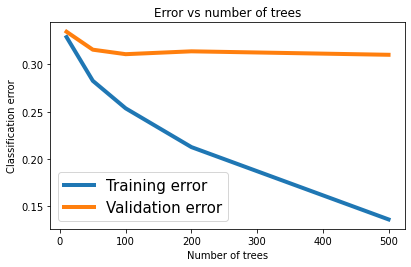

In [162]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')

Quiz: Does the training error reduce as the number of trees increases?
    
Answer: Yes
    
Quiz: Is it always true that the test/validation error will reduce as the number of trees increases?

Answer: No